# Lab 3 : Diving Into Quantum Algorithms
***

## Section 1: QPE


<img src="./resources/qpe_tex_qz.png" alt="QPE Circuit" style="width: 800px;"/>


Here we will construct a set of functions to generate a Quantum Phase Estimation circuit.

*What will students do?*:
1. Generate a QPE circuit with an arbitrary number of counting qubits
    1. Give hint to start at 4 or other small number and modularize it
1. Use the QPE circuit to construct Shor's algorithm for small integers.
    

In [1]:
import qiskit as qk
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd



In [280]:
#QFT Circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = qk.QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
#def qft_dagger(qc, n):
#    """n-qubit QFTdagger the first n qubits in circ"""
#    # Don't forget the Swaps!
#    for qubit in range(n//2):
#        qc.swap(qubit, n-qubit-1)
#    for j in range(n):
#        for m in range(j):
#            qc.cp(-np.pi/float(2**(j-m)), m, j)
#        qc.h(j)

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = qk.QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

### Step 1: Set up a QPE Circuit with four counting qubits



Let's pick a phase gate with $\theta = \frac{1}{3}$ as a simple example unitary to test creating a QPE circuit.  Here we'll use Qiskit's `PhaseGate` which applies $P|1\rangle{}=e^{i\lambda}|1\rangle{}$.  Since we want to examine QPE under a unitary with the form $U|1\rangle{}=e^{i2\pi \theta}$, we should set $\lambda=\frac{2\pi}{3}$.

Create a QPE circuit with four counting qubits and name the circuit `qpe4`.  It may be helpful to define two `QuantumRegister` objects, one for the "system" where the unitary will be applied and one for where the phase information will be stored.  Feel free to reference the Qiskit Textbook's chapter on [Quantum Phase Estimation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation#getting_more_precision).

It should look something like this:

<img src="./resources/qpe4_circuit.png" alt="QPE 4 Phase Circuit" style="width: 1000px;"/>


In [211]:

phase_register_size = 4
qpe4 = qk.QuantumCircuit(phase_register_size+1, phase_register_size)

### Insert your code here
for i in range(phase_register_size):
    qpe4.h(i)
    
qpe4.x(4)

qpe4.cp(2*np.pi/3, 0, 4)

t = 2
for i in range(t):
    qpe4.cp(2*np.pi/3, 1, 4)

t *= 2
for i in range(t):
    qpe4.cp(2*np.pi/3, 2, 4)

t *= 2
for i in range(t):
    qpe4.cp(2*np.pi/3, 3, 4)

#qpe4.barrier()
qpe4.swap(0, 3)
qpe4.h(0)
qpe4.swap(1, 2)
qpe4.cp(-np.pi/2, 0, 1)
qpe4.h(1)
qpe4.cp(-np.pi/4, 0, 2)
qpe4.cp(-np.pi/2, 1, 2)
qpe4.cp(-np.pi/8, 0, 3)
qpe4.h(2)
qpe4.cp(-np.pi/4, 1, 3)
qpe4.cp(-np.pi/2, 2, 3)
qpe4.h(3)

qpe4.measure(0, 0)
qpe4.measure(1, 1)
qpe4.measure(2, 2)
qpe4.measure(3, 3)


Now use the `AerSimulator` to simulate this circuit and plot the histogram of the results.  Use 2000 shots.


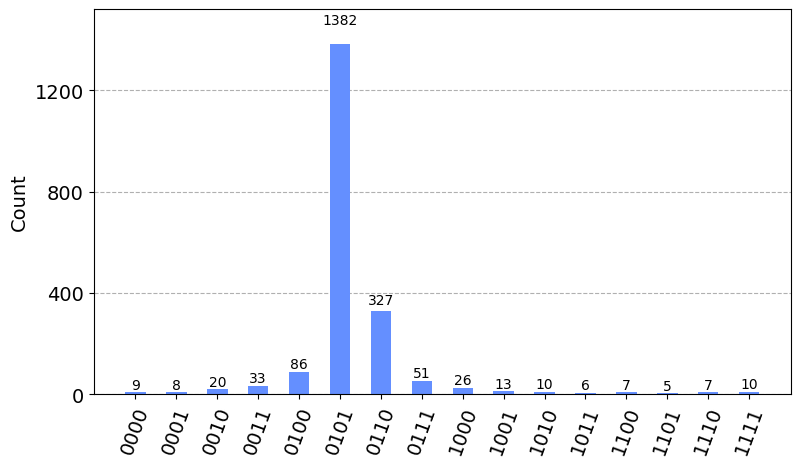

In [10]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = qk.Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = qk.execute(qpe4, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

In [11]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex1 

grade_lab3_ex1(count_qpe4)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Next write a function to process the bit strings into the estimate of $\theta$.  Recall that the phase estimate is written in the form:

$$ \theta = 0.\theta_1\theta_2\theta_3...\theta_t = \frac{\theta_1}{2^1} + \frac{\theta_2}{2^2} + \frac{\theta_3}{2^3} + ... + \frac{\theta_t}{2^t} $$

where $\theta_i = \{0,1\}$.  What is the estimated phase?  To within what power of 2 is the estimate accurate up to given your choice of the number of counting qubits (e.g. $2^{-2}$, $2^{-3}$, $2^{-4}$, etc.)?



In [12]:

#Grab the highest probability measurement
max_binary_counts = 0
max_binary_val = ''
for key, item in count_qpe4.items():
    if item > max_binary_counts:
        max_binary_counts = item
        max_binary_val = key

## Your function to convert a binary string to decimal goes here
print(max_binary_counts)
print(max_binary_val)


estimated_phase = int(max_binary_val, 2)/(2**len(max_binary_val))
actual_phase = 1/3
phase_accuracy = abs(estimated_phase-actual_phase)/actual_phase

print(estimated_phase)
print(phase_accuracy)



1382
0101
0.3125
0.062499999999999944


In [13]:

from qc_grader.challenges.qgss_2023 import grade_lab3_ex2 

grade_lab3_ex2([estimated_phase, phase_accuracy])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2: Run on Noisy Hardware

Now run this circuit using your favorite backend!  Transpile this circuit a number of times (you pick how many) and pick the one with the lowest and highest circuit depth. 

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qpe4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well to compare against, name them `min_depth_qpe` and `max_depth_qpe`.



In [286]:
from qiskit_ibm_provider import IBMProvider
from qiskit import transpile


provider = IBMProvider()
hub = "summer-school-ea"
group = "group-1"
project = "648fee6159757756"
backend_name = "ibmq_manila"

backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

# your code goes here
depths = []
for i in range(5):
    depths.append(transpile(qpe4, backend=backend, optimization_level=3))

for i in depths:
    print('depth = ', i.depth())


depth =  79
depth =  76
depth =  79
depth =  79
depth =  79


In [38]:
min_depth_qpe = depths[0]
max_depth_qpe = depths[-1]

In [39]:
shots = 2000

#Run the minimum depth qpe circuit
job_min_qpe4 = backend.run(min_depth_qpe, sim, shots=shots)
print(job_min_qpe4.job_id())

#Gather the count data
count_min_qpe4 = job_min_qpe4.result().get_counts()
plot_histogram(count_min_qpe4, figsize=(9,5))

cibbfl0k82m1odf75vv0


KeyboardInterrupt: 

In [ ]:

#Run the maximum depth qpe circuit
job_max_qpe4 = backend.run(max_depth_qpe, sim, shots=shots)
print(job_max_qpe4.job_id())

#Gather the count data
count_max_qpe4 = job_max_qpe4.result().get_counts()
plot_histogram(count_max_qpe4, figsize=(9,5))

In [40]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex3

grade_lab3_ex3([max_depth_qpe, min_depth_qpe])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3: Try with a different $\theta$

Now try the same procedure with $\theta = \frac{1}{5}$.  Rewrite your code written above to create a function which generates a QPE circuit with $n$ register qubits.  How many register qubits storing the phase information are needed for the estimate to be accurate to within $2^{-3}$? 

*Hint: It may be easier to iterate over different phase register sizes by creating a callable function. Perhaps call it* `qpe_circuit`

In [41]:


def qpe_circuit(register_size):

    # Your code goes here
    
    
    return qpe
    



In [ ]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
reg_size = # Vary the register sizes

qpe_check = qpe_circuit(reg_size)
sim = qk.Aer.get_backend('aer_simulator')
shots = 2000
count_qpe4 = qk.execute(qpe_check, sim, shots=shots).result().get_counts()
plot_histogram(count_qpe4, figsize=(9,5))

In [ ]:


# Process the count data to determine accuracy of the estimated phase





In [50]:
required_register_size = 8 #your answer here

In [51]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex4

grade_lab3_ex4(required_register_size)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Section 2: Shor's Algorithm
***

Here we will construct a set of functions to implement Shor's algorithm.  Remember that the goal of this algorithm is to find the prime factors of some large number $N$ and the key speedup this algorithm provides is by executing the period-finding part using a quantum computer.  This is where this section of the lab will focus.

*What will students do?*:
1. Construct a compiled version of Shor's algorithm

Recall the Shor's algorithm is composed of the following steps:
1. Choose a co-prime $a$, where $a\in [2,N-1]$ and the greatest common divisor of $a$ and $N$ is 1.
1. Find the order (periodicity) of $a$ modulo $N$, i.e. the smallest integer $r$ such that $a^r\text{mod} N=1$
1. Obtain the factor of $N$ by computing the greatest common divisor of $a^{r/2} \pm 1$ and $N$.

## Step 1. Period Finding

To begin, we'll use the unitary operator: $$ U|y\rangle{} \equiv |ay\ \text{mod} N\rangle{} $$


and explore the superposition state: 
$$
|u\rangle{} = \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{-\frac{2\pi ik}{r}}|a^k \text{mod}N\rangle{}
$$

Let's pick $a=3$ and $N=35$ as an example and investigate what the action of $U$ is on $|u\rangle{}$
\begin{align}
    U|u\rangle{} &= U\frac{1}{\sqrt{r}}\left( |1\rangle{} + e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} \right) \\
    & =\frac{1}{\sqrt{r}}\left( U|1\rangle{} + e^{-\frac{2\pi i}{r}}U|3\rangle{} + e^{\frac{-4\pi i}{r}}U|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}U|4\rangle{} + e^{\frac{-22\pi i}{r}}U|12\rangle{} \right) \\
    &= \frac{1}{\sqrt{r}}\left( |3\rangle{} + e^{-\frac{2\pi i}{r}}|9\rangle{} + e^{\frac{-4\pi i}{r}}|27\rangle{} + ... + e^{\frac{-20\pi i}{r}}|12\rangle{} + e^{\frac{-22\pi i}{r}}|1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}}\left( e^{-\frac{2\pi i}{r}}|3\rangle{} + e^{\frac{-4\pi i}{r}}|9\rangle{} + ... + e^{\frac{-20\pi i}{r}}|4\rangle{} + e^{\frac{-22\pi i}{r}}|12\rangle{} + |1\rangle{} \right) \\
    &= \frac{e^{\frac{2\pi i}{r}}}{\sqrt{r}} |u\rangle{}.
\end{align}


This is a particularly helpful eigenvalue as it contains $r$.  In fact, it needs to be included in order to ensure the phase differences between the basis states are equal.  This is also not the only eigenstate of $U$.  FOr us to generalize further, we can multiply an integer $s$ to each of these phases, which will then show up in our eigenvalue

\begin{align}
    |u_s\rangle{} &= \frac{1}{\sqrt{r}}\sum_{k=0}^{r-1} e^{\frac{-2\pi isk}{r}|a^k\text{mod} N\rangle{}} \\
    U|u_s\rangle{} &= e^{\frac{2\pi is}{r}}|u_s\rangle{}.
\end{align}


Now we have an eigenstate for each integer $0 \leq s \leq r$.  Notably, if we add up all of these eigenstates, the phases cancel all other basis states except $|1\rangle{}$ $$ \frac{1}{\sqrt{r}} \sum_{s=0}^{r-1}|u_s\rangle{} = |1\rangle{} $$.


Since any state in the computational basis can be written as a linear combination of these eigenstates, if we do QPE on $U$ using the state $|1\rangle{}$, we will measure a phase 

$$ \phi = \frac{s}{r} $$
where $s$ is a random integer between $0$ and $r-1$.  Finally, we can use a method called the continued fraction algorithm on $\phi$ in order to find r.  The final circuit will look something like this



<img src="./resources/Shor_circuit.png" alt="Short Circuit" style="width: 1000px;"/>


***

Below we'll provide the unitary $U$ needed for solving this period finding problem with $a=7$ and $N=15$

$$ 
    U|y\rangle{} = |7y\text{mod}15\rangle{}.
$$

To create $U^x$ we will simply repeat the circuit $x$ times.  The cell below will construct this unitary

In [97]:
## Create 7mod15 gate
N = 15
m = int(np.ceil(np.log2(N)))

U_qc = qk.QuantumCircuit(m)
U_qc.x(range(m))
U_qc.swap(1, 2)
U_qc.swap(2, 3)
U_qc.swap(0, 3)

U = U_qc.to_gate()
U.name ='{}Mod{}'.format(7, N)

Confirm if the operator $U$ works as intended by creating a quantum circuit with $m$ qubits.  Prepare the inpute state representing any integer between $0$ and $15$ (remembering that Qiskit uses little endian notation) such as $|1\rangle{} = |0001\rangle{}$, $|5\rangle{} = |0101\rangle{}$, etc. and apply the $U$ gate to it.  Check if the circuit produces the expected outcomes for several inputs: $|1\rangle{}$, $|3\rangle{}$, and $|5\rangle{}$.  Run these circuits through the `aer_simulator` backend with $10000$ shots, save the count data as `input_1`, `input_3`, and `input_5`.

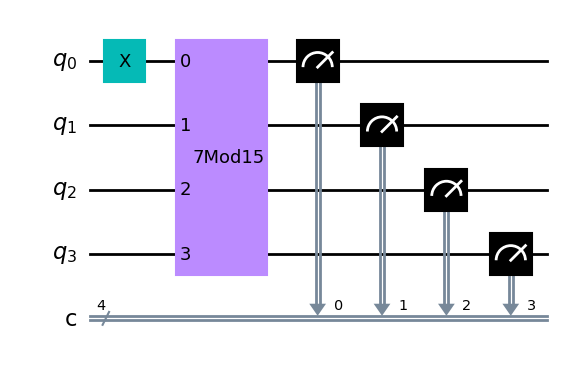

In [288]:
### your code goes here

qcirc1 = qk.QuantumCircuit(m, m)
qcirc1.x(0)
for i in range(1):
    qcirc1.append(U, (i for i in range(m)))

for i in range(m):
    qcirc1.measure(i, i)


qcirc3 = qk.QuantumCircuit(m, m)
#qcirc3.x(0)
qcirc3.x(1)
#qcirc3.x(3)
for i in range(2):
    qcirc3.append(U, (i for i in range(m)))

for i in range(m):
    qcirc3.measure(i, i)


qcirc5 = qk.QuantumCircuit(m, m)
qcirc5.x(0)
qcirc5.x(2)
for i in range(5):
    qcirc5.append(U, (i for i in range(m)))

for i in range(m):
    qcirc5.measure(i, i)
    
qcirc1.draw()
#qcirc3.draw()
#qcirc5.draw()

In [289]:
## Run this cell to simulate 'qpe4' and to plot the histogram of the result
sim = qk.Aer.get_backend('aer_simulator')
shots = 20000
#count_qpe4 = qk.execute(qcirc, sim, shots=shots).result().get_counts()

input_1 = qk.execute(qcirc1, sim, shots=shots).result().get_counts() # save the count data for input 1
input_3 = qk.execute(qcirc3, sim, shots=shots).result().get_counts() # save the count data for input 2
input_5 = qk.execute(qcirc5, sim, shots=shots).result().get_counts() # save the count data for input 5

plot_histogram(input_3, figsize=(9,5))
print(input_1)
print(input_3)
print(input_5)

{'0111': 20000}
{'1000': 20000}
{'0101': 20000}


In [203]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex5

#input_1 = {'0111': shots}
#input_3 = {'1110': shots}
#input_5 = {'0101': shots}

grade_lab3_ex5([input_1, input_3, input_5])

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 2. Implementing $U^{2^{m-1}}$

Now we'll use this controlled-$U$ to estimate the phase $\phi=\frac{s}{r}$.  First create a quantum circuit with $m=4$ qubits implementing the `7mod15` gate $2^2$ times and run it on the `unitary_simulator` backend to obtain the matrix represenation of the gates in the circuit.  Verify $U^2=I$.

In [214]:

unitary_circ = qk.QuantumCircuit(m)

# Your code goes here
for i in range(4):
    unitary_circ.append(U, (i for i in range(m)))



In [215]:
sim = qk.Aer.get_backend('unitary_simulator')
unitary = qk.execute(unitary_circ, sim).result().get_unitary()

In [216]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex6

grade_lab3_ex6(unitary)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 3. Finding $\phi$ and Continued Fractions


Now armed with a way to execute $U^{2^{m-1}}$, let's use it in the QPE circuit you created earlier.  Below is a function to construct a controlled-$U$ gate. Use $8$ phase register qubits and, using the `aer_simulator` again, estimate the phase $\phi$ given an input state of $|1\rangle{}$.

*Hint: at each step in the QPE circuit, you'll need to construct a new `cU_multi` circuit and append it to the QPE circuit. There will be several estimates that have approximately equal probability.*

In [207]:
def cU_multi(k, m):
    circ = qk.QuantumCircuit(m)
    for _ in range(2**k):
        circ.append(U, range(m))
    
    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)
    
    cU_multi = U_multi.control()
    return cU_multi

In [232]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = qk.QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

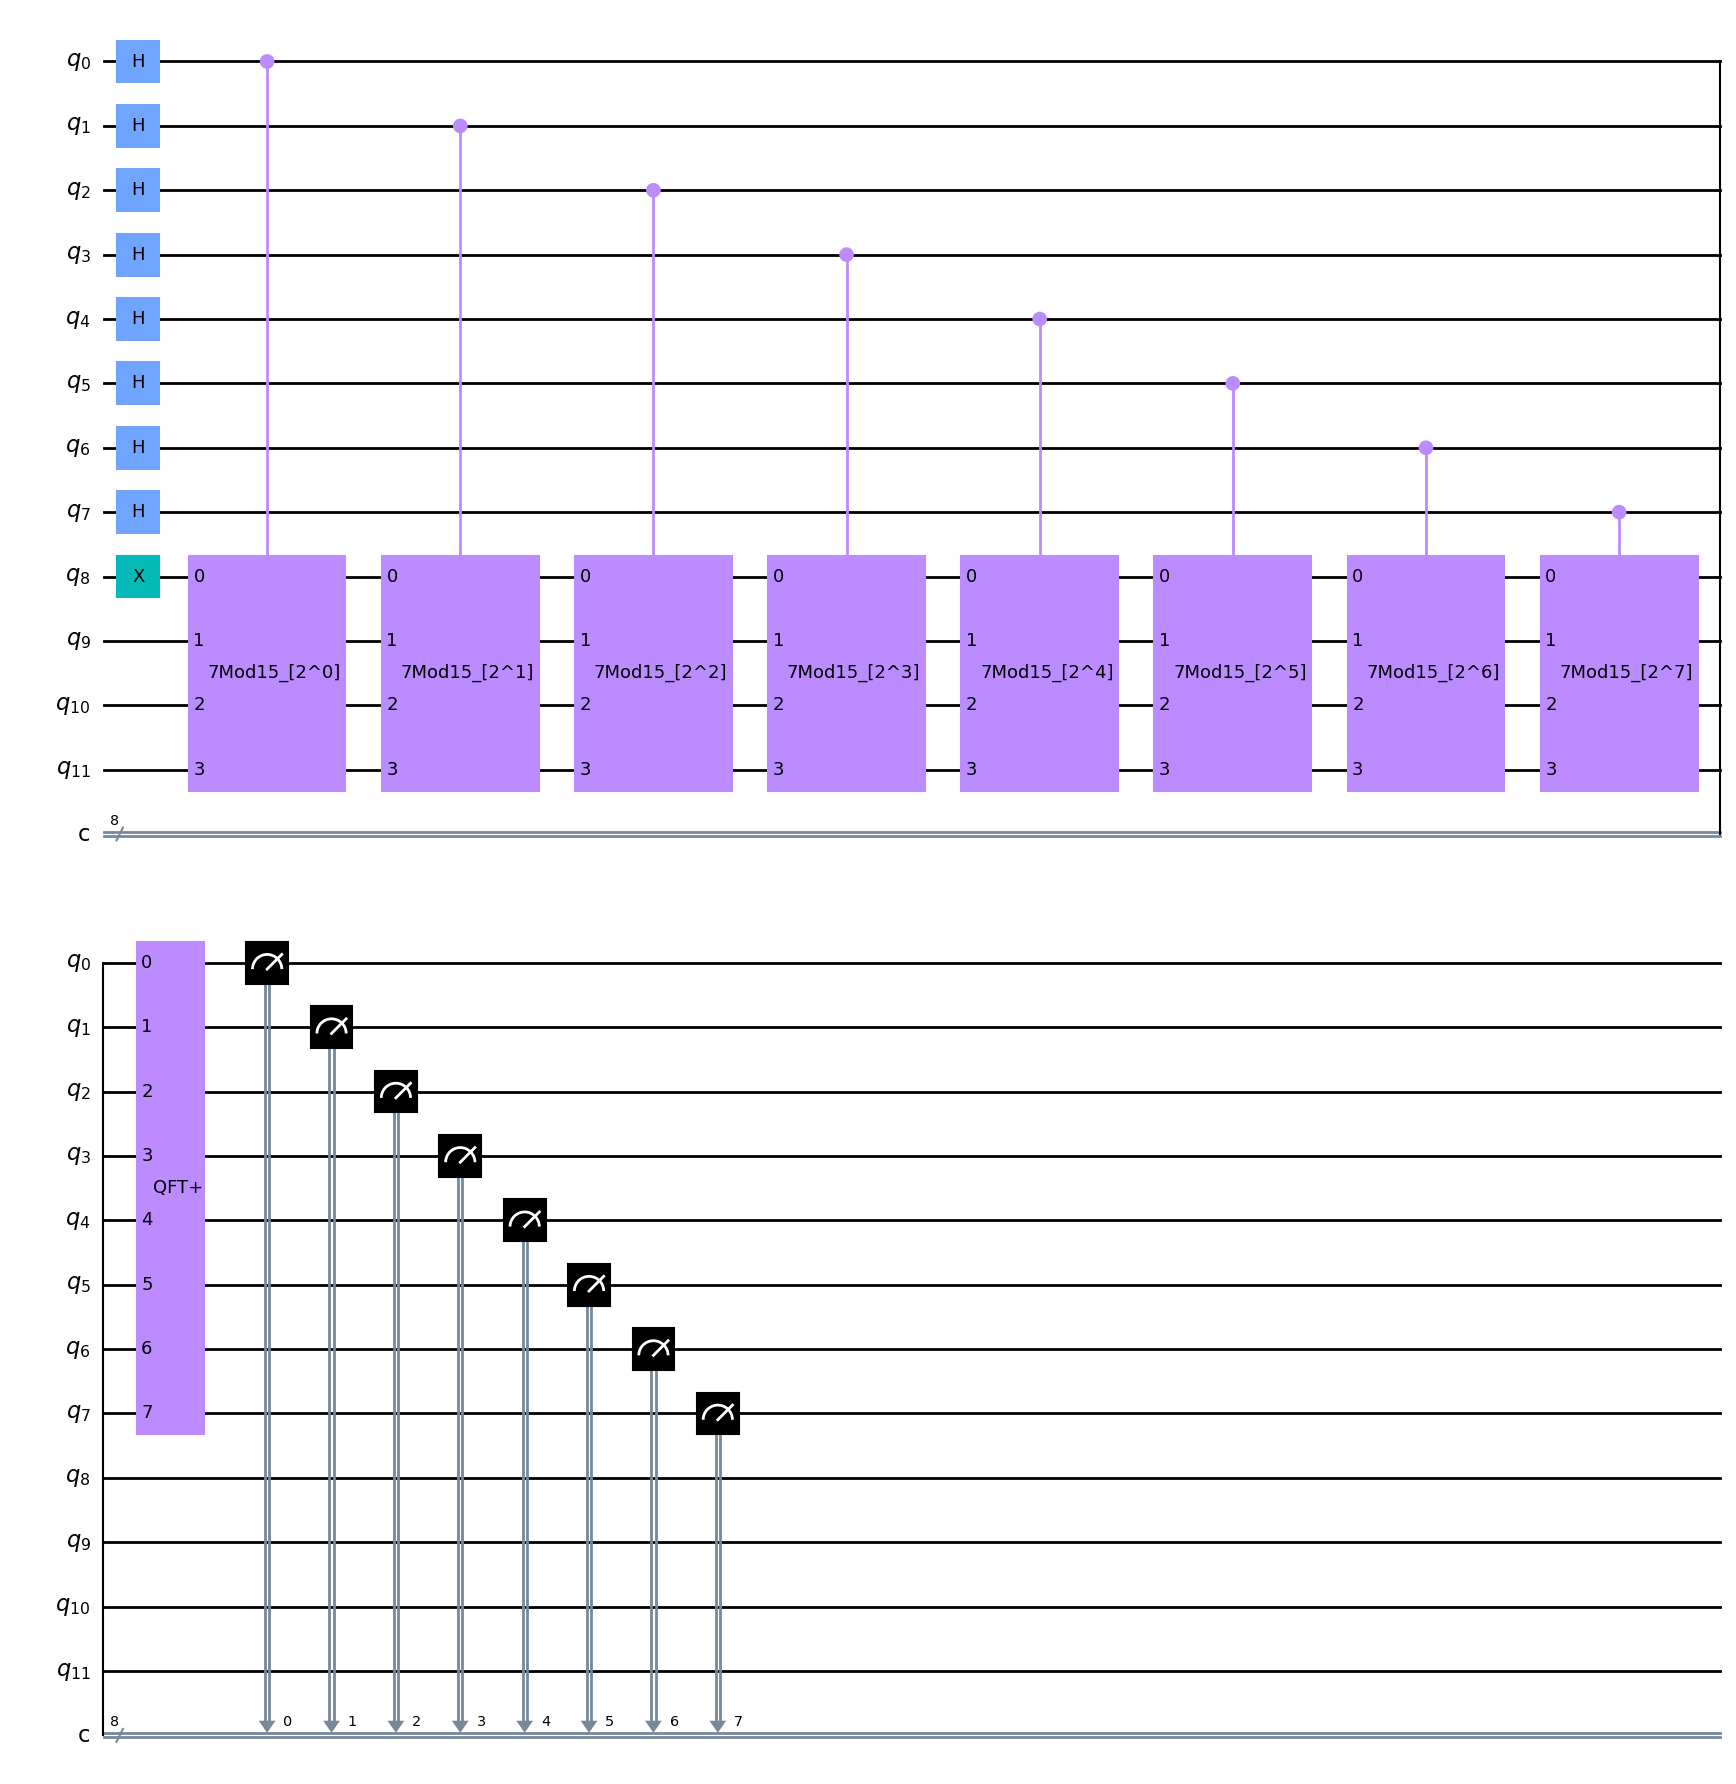

In [234]:

# your code goes here
#Create the QuantumCircuit needed to run with 8 phase register qubits

t = 2*m

shor_qpe = qk.QuantumCircuit(t+m, t)
shor_qpe.h(range(t))

shor_qpe.x(t)
for idx in range(t):
    shor_qpe.append(cU_multi(idx, m), [idx]+ list(range(t,t+m)))

qft_dag = qft(t).inverse()
qft_dag.name = 'QFT+'
shor_qpe.append(qft_dag, range(t))

shor_qpe.measure(range(t), range(t))

shor_qpe.draw()

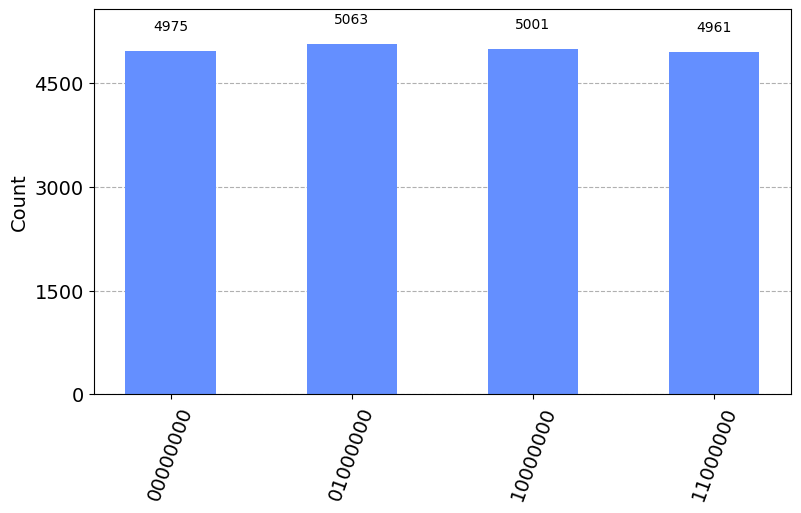

In [235]:
## Run this cell to simulate 'shor_qpe' and to plot the histogram of the results
sim = qk.Aer.get_backend('aer_simulator')
shots = 20000
shor_qpe_counts = qk.execute(shor_qpe, sim, shots=shots).result().get_counts()
plot_histogram(shor_qpe_counts, figsize=(9,5))

In [236]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex7

grade_lab3_ex7(shor_qpe_counts)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We can then find the integers $s$ and $r$ using the continued fractions algorithm.  Luckily python has built-in functionality for this using the `Fraction` function, where we will limit the denominator to $r<15$.  Use this to find the estimated $s$ and $r$ for each outcome you measured above.

In [237]:
from fractions import Fraction
print(Fraction(0.666), '\n')
print(Fraction(0.666).limit_denominator(15))

5998794703657501/9007199254740992 

2/3


In [254]:

shor_qpe_fractions = [
    Fraction(0.25).limit_denominator(15),
    Fraction(0.25).limit_denominator(15),
    Fraction(0.25).limit_denominator(15),
    Fraction(0.25).limit_denominator(15)
] # create a list of Fraction objects for each measurement outcome


In [255]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex8

grade_lab3_ex8(shor_qpe_fractions)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Step 4. Putting it all together

Now let's put all of these steps together in order to factor the (very simple) number,  $N = 15$.  We'll continue with our example of $a=7$, remember that the phase we measure $s/r$ where $s$ is a random integer between $0$ and $r-1$ and:

$$
    a^r\text{mod}N = 1
$$

Then, once we have $r$, we can find a factor of $N$ by:

$$
    \left(a^r-1\right)\text{mod} N = 0
$$
which requires that $N$ must divide by $a^r-1$.  If $r$ is even, we can also write

$$
    a^r-1 = \left(a^{r/2}+1\right)\left(a^{r/2}-1\right).
$$

Put together a function called `shor_qpe` which takes arguments for $a$ (a random co-prime where $a\in [2,N-1]$) and $k$ (the number of counting qubits) and composes, runs, and processes Shor's algorithm to guess the factors.

In [276]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = qk.QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [283]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = qk.QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = qk.Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(qk.transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

In [284]:
def shor_qpe(a, k):


    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###


        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###


        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###


        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###


        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        #guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
    
    #Step 6. If a nontrivial factor is found return the list 'guesses', otherwise
    # continue the while loop
    ### Your code goes here ###
    
    FACTOR_FOUND = False
    ATTEMPT = 0
    while not FACTOR_FOUND:
        ATTEMPT += 1
        #print(f"\nATTEMPT {ATTEMPT}:")
        phase = qpe_amod15(a) # Phase = s/r
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        #print(f"Result: r = {r}")
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
            #print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            for guess in guesses:
                if guess not in [1,N] and (N % guess) == 0:
                    # Guess is a factor!
                    #print("*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True
    
    return guesses

In [287]:
from qc_grader.challenges.qgss_2023 import grade_lab3_ex9

grade_lab3_ex9(shor_qpe)

Register Reading: 10000000
Corresponding Phase: 0.5
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Congratulations! You've completed Lab 3 of the Global Summer School!! 🎉

This lab was adapted from both the [Qiskit QPE Lab](https://learn.qiskit.org/course/ch-labs/lab-5-accuracy-of-quantum-phase-estimation#lab-3-0) as well as the [Qiskit Shor's Algorithm](https://learn.qiskit.org/course/ch-labs/lab-7-scalable-shors-algorithm) lab